In [92]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import as_float_array

In [54]:
class AddTime(BaseEstimator, TransformerMixin):
    def __init__(self, init_time=0., total_time=1.):
        self.init_time = init_time
        self.total_time = total_time

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        t = np.linspace(self.init_time, self.init_time + 1, len(X))
        return np.c_[t, X]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

In [55]:
class LeadLag(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        lag = []
        lead = []

        for val_lag, val_lead in zip(X[:-1], X[1:]):
            lag.append(val_lag)
            lead.append(val_lag)

            lag.append(val_lag)
            lead.append(val_lead)

        lag.append(X[-1])
        lead.append(X[-1])

        return np.c_[lag, lead]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

In [96]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [221]:
# Helper function that extract rolling windows of historical prices of size h and means of the next future f prices.
def GetWindow(x, h_window=30, f_window=10):
    
    # LeadLag, AddTime
    ll = LeadLag()
    tt = AddTime()

    # First window
    x_ = [tt.transform_instance(ll.transform_instance(x[:h_window]))]
    
    # Append next window
    for i in trange(1,len(x)-h_window+1):
        x_i = x[i:i+h_window]
        x_.append(tt.transform_instance(ll.transform_instance(x_i)))
    
    # Cut the end that we can't use to predict future price
    return np.stack(x_)[:-f_window,:,:]

def GetNextMean(x, h_window=30, f_window=10):
    return x.rolling(f_window).mean().iloc[h_window+f_window-1:,].values

In [181]:
def PlotResult(y_train, y_test, y_train_predict, y_test_predict, 
               error_train, error_test, p_error_train, p_error_test, name='VOSF'):
    
    train_len = len(y_train)
    test_len = len(y_test)
            
    #Visualise
    fig, ax = plt.subplots(1, figsize=(12, 5))
    ax.plot(y_train_predict,color='red')

    ax.plot(range(train_len, train_len+test_len),
            y_test_predict,
            label='Predicted average price',
            color='red',linestyle = '--')

    ax.plot(np.array((y_train).append(y_test)),
             label='Actual average price',
             color='green')

    ax.axvspan(len(y_train), len(y_train)+len(y_test),
                alpha=0.3, color='lightgrey')
    
    ax.plot([], [], ' ', label='\ntrain:  MAE={0:.3f}  MAPE={1:.3f}%'.format(error_train, p_error_train))
    ax.plot([], [], ' ', label='test:   MAE={0:.3f}  MAPE={1:.3f}%'.format(error_test, p_error_test))

    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best")
#     plt.savefig('../pictures/bitcoin_prices_prediction_{}'.format(name))
    plt.show()

In [182]:
#data is from https://www.cryptodatadownload.com/data/gemini/
# BTC_price_15 = pd.read_csv('../data/gemini_BTCUSD_2015_1min.csv',header=1)
# BTC_price_16 = pd.read_csv('../data/gemini_BTCUSD_2016_1min.csv',header=1)
BTC_price_17 = pd.read_csv('../data/gemini_BTCUSD_2017_1min.csv',header=1)
BTC_price_18 = pd.read_csv('../data/gemini_BTCUSD_2018_1min.csv',header=1)
# BTC_price_19 = pd.read_csv('../data/gemini_BTCUSD_2019_1min.csv',header=1)
# BTC_price_20 = pd.read_csv('../data/gemini_BTCUSD_2020_1min.csv',header=1)

In [228]:
BTC_price = pd.concat([BTC_price_18, BTC_price_17])

In [229]:
#drop the first column and reverse order
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['Date'] = pd.to_datetime(BTC_price['Date'])
BTC_price.set_index('Date', inplace=True)

In [230]:
# select duration
initial_date = '2017-10-01 00:00:00'
finish_date = '2018-04-01 00:00:00'
BTC_price = BTC_price[initial_date:finish_date]

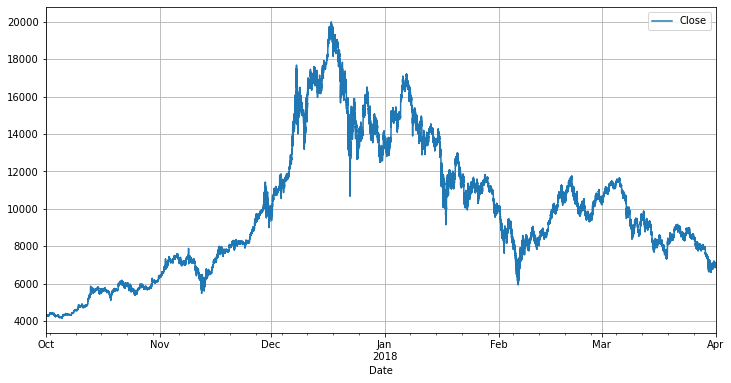

In [231]:
ax = BTC_price.plot(y='Close', figsize=(12,6), legend=True, grid=True, use_index=True)
plt.show()

In [232]:
len(BTC_price.index)

262081

In [233]:
# We use only close price
close_price = BTC_price.loc[:,'Close']
close_price = TimeSeriesScalerMeanVariance().fit_transform(close_price.values[None,:])
close_price = pd.DataFrame(np.squeeze(close_price))

In [234]:
h_window = 6*30
f_window = 30

In [239]:
# mean next price
y = GetNextMean(close_price, h_window = h_window , f_window = f_window)

In [240]:
# normal window features
X_window = GetWindow(close_price.values, h_window, f_window)

In [241]:
pickle.dump(X_window, open('X_window.obj', 'wb'))
pickle.dump(y, open('y.obj', 'wb'))

In [94]:
# X_window = pickle.load(open('X_window.obj', 'rb'))
# y = pickle.load(open('y.obj', 'rb'))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_window, y, test_size=0.2, shuffle=False)

In [48]:
# # calculate errors
# error_train = mean_absolute_error(y_train, y_train_predict)        
# error_test = mean_absolute_error(y_test, y_test_predict)
# p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
# p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

# # plot results
# PlotResult(y_train, y_test, y_train_predict, y_test_predict, 
#            error_train, error_test, p_error_train, p_error_test, 'VOSF')